# Get the data
---

/tmp/ipykernel_2075205/298430765.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, new_rows], ignore_index=True)
/tmp/ipykernel_2075205/298430765.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, new_rows], ignore_index=True)
/tmp/ipykernel_2075205/298430765.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns 

All datasets have been loaded.


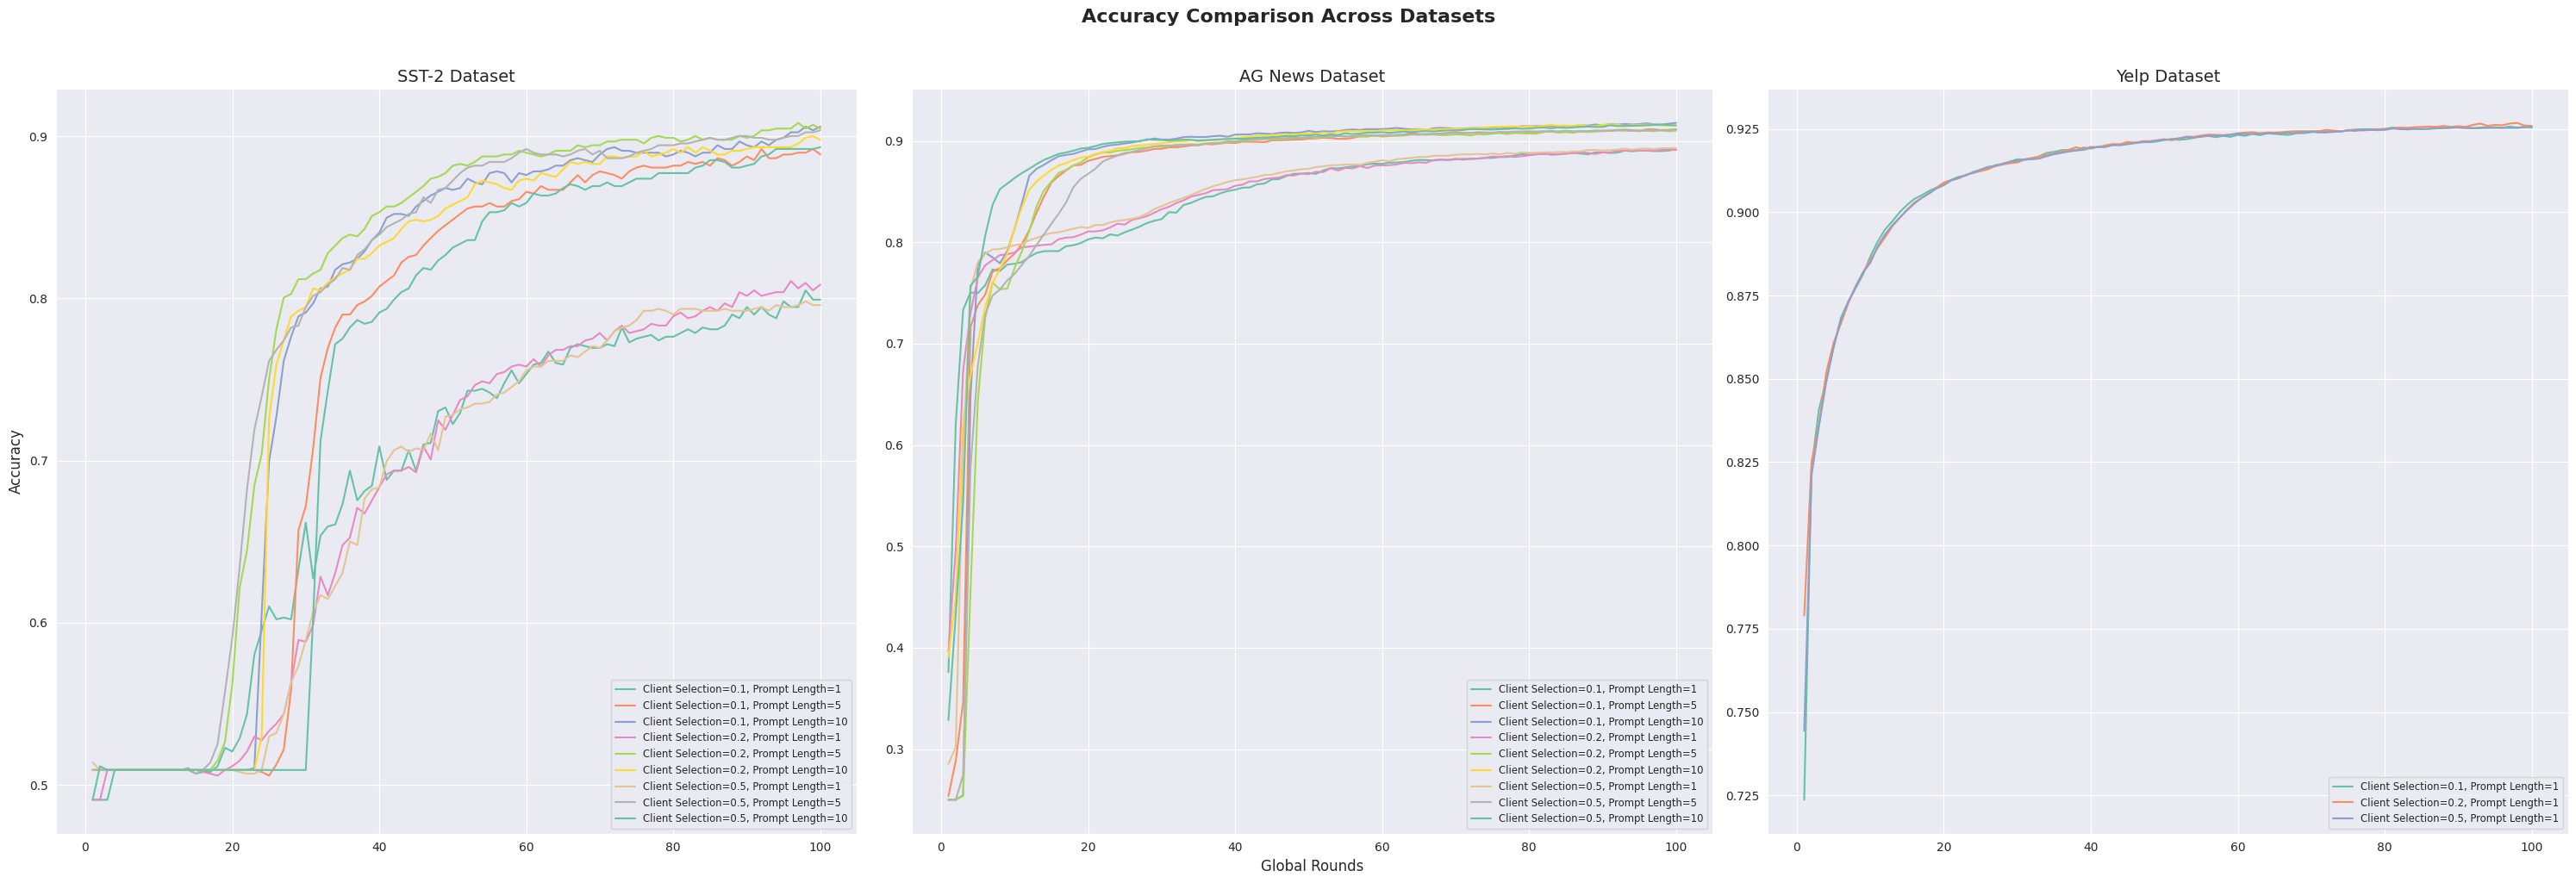

In [73]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dataset_name_dict = {
    'agnews': 'AG News',
    'sst2': 'SST-2',
    'yelp': 'Yelp'
}

# Dataset names
dataset_names = ['sst2', 'agnews', 'yelp']
do_save = True

# Function to load data for a specific dataset
def load_dataset(dataset_name):
    
    directory_path = f'./archive/12_final_{dataset_name}'
    df_all = pd.DataFrame(columns=['fraction', 'prompt_length', 'acc'])
    
    for filename in os.listdir(directory_path):
        if filename.endswith('.csv'):
            parts = filename.split('_')
            fraction = parts[6][1:]
            prompt_length = parts[9][1:]
            
            if fraction and prompt_length:
                file_path = os.path.join(directory_path, filename)
                df = pd.read_csv(file_path)
                
                new_rows = pd.DataFrame({
                    'fraction': [float(fraction)] * len(df),
                    'prompt_length': [int(prompt_length)] * len(df),
                    'acc': df['value']
                })
                
                df_all = pd.concat([df_all, new_rows], ignore_index=True)
    
    return df_all

# Function to filter df_all based on fraction and prompt_length
def get_filtered_df(df, f, p):
    return df[(df['fraction'] == f) & (df['prompt_length'] == p)]

# Load data for each dataset
dataset_data = {name: load_dataset(name) for name in dataset_names}

print("All datasets have been loaded.")

# Plot and save

# Set the style for the plot
sns.set_style("darkgrid")
palette = "Set2"

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

# Add a main title to the figure
fig.suptitle('Accuracy Comparison Across Datasets', fontsize=16, fontweight='bold', y=1.02)

# Get unique combinations of fraction and prompt_length
combinations = dataset_data['sst2'][['fraction', 'prompt_length']].drop_duplicates()

# Sort the combinations
combinations = combinations.sort_values(['fraction', 'prompt_length'])

# Create a color palette with enough colors
color_palette = sns.color_palette(palette, n_colors=len(combinations))

# ... existing code ...

for idx, dataset in enumerate(dataset_names):
    df_all = dataset_data[dataset]

    if dataset == 'yelp':
        # Specific code for yelp dataset
        yelp_combinations = df_all[['fraction', 'prompt_length']].drop_duplicates()
        yelp_combinations = yelp_combinations.sort_values(['fraction', 'prompt_length'])
        yelp_color_palette = sns.color_palette(palette, n_colors=len(yelp_combinations))
        
        for i, (fraction, prompt_length) in enumerate(yelp_combinations.values):
            data = get_filtered_df(df_all, fraction, prompt_length)
            data = data.sort_index()
            sns.lineplot(x=range(1, 101), y='acc', data=data, 
                         label=f'Client Selection={fraction}, Prompt Length={prompt_length}',
                         color=yelp_color_palette[i], ax=axes[idx])
    else:
        # Plot each combination for other datasets
        for i, (fraction, prompt_length) in enumerate(combinations.values):
            data = get_filtered_df(df_all, fraction, prompt_length)
            data = data.sort_index()
            sns.lineplot(x=range(1, 101), y='acc', data=data, 
                         label=f'Client Selection={fraction}, Prompt Length={prompt_length}',
                         color=color_palette[i], ax=axes[idx])

    # Set labels and title for each subplot
    axes[idx].set_title(f'{dataset_name_dict[dataset]} Dataset', fontsize=14)
    
    # Remove y-label from all but the leftmost plot
    if idx == 0:
        axes[idx].set_ylabel('Accuracy', fontsize=12)
    else:
        axes[idx].set_ylabel('')
    
    # Remove x-label from all but the middle plot
    if idx == 1:
        axes[idx].set_xlabel('Global Rounds', fontsize=12)
    else:
        axes[idx].set_xlabel('')
    
    # Add legend to the bottom right of each subplot
    axes[idx].legend(loc='lower right', fontsize='small')

# Adjust layout and save
plt.tight_layout()

if do_save:
    plt.savefig('figures/feddpg_accuracy_results.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

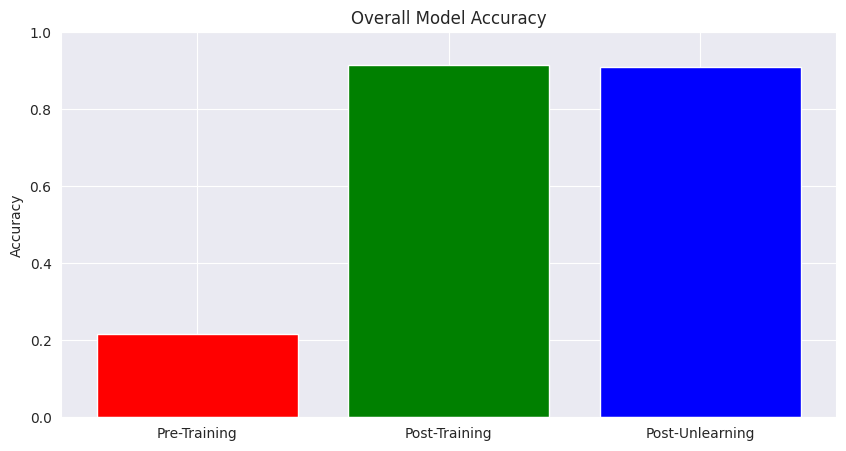

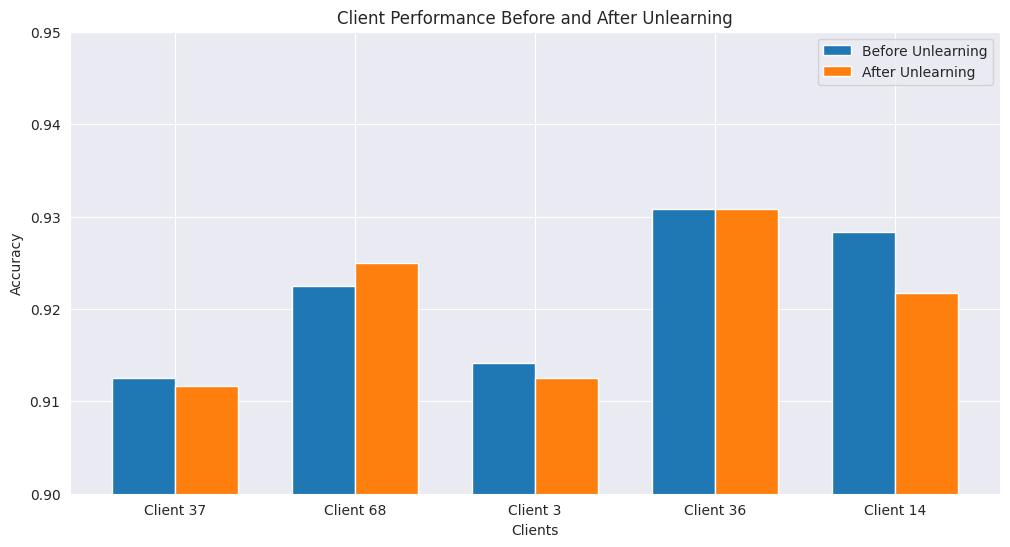

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Data
overall_accuracies = {
    'Pre-Training': 0.2153,
    'Post-Training': 0.9146,
    'Post-Unlearning': 0.9105
}

clients = ['Client 37', 'Client 68', 'Client 3', 'Client 36', 'Client 14']
before_unlearning = [0.9125, 0.9225, 0.9142, 0.9308, 0.9283]
after_unlearning = [0.9117, 0.9250, 0.9125, 0.9308, 0.9217]

# Plotting overall accuracies
plt.figure(figsize=(10, 5))
plt.bar(overall_accuracies.keys(), overall_accuracies.values(), color=['red', 'green', 'blue'])
plt.title('Overall Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Plotting client performance
x = np.arange(len(clients))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, before_unlearning, width, label='Before Unlearning')
bars2 = ax.bar(x + width/2, after_unlearning, width, label='After Unlearning')

ax.set_xlabel('Clients')
ax.set_ylabel('Accuracy')
ax.set_title('Client Performance Before and After Unlearning')
ax.set_xticks(x)
ax.set_xticklabels(clients)
ax.legend()

plt.ylim(0.9, 0.95)  # Adjust the y-axis limits for better visibility
plt.show()

In [70]:
import re
import pandas as pd

def extract_accuracies_from_log(log_file_path):
    # Initialize dictionaries to store overall and client accuracies
    overall_accuracies = {}
    client_accuracies = {'Client': [], 'Before Unlearning': [], 'After Unlearning': [], 'Change': []}

    # Regular expressions to match the relevant lines in the log
    overall_pattern = re.compile(r'Pre-Training accuracy: (\d+\.\d+)|Post-Training accuracy: (\d+\.\d+)|Post-Unlearning accuracy: (\d+\.\d+)')
    client_pattern = re.compile(r'Client (\d+): Before Unlearning accuracy: (\d+\.\d+), After Unlearning accuracy: (\d+\.\d+), Change: ([\-\d\.]+)')

    with open(log_file_path, 'r') as file:
        for line in file:
            # Match overall accuracies
            overall_match = overall_pattern.search(line)
            if overall_match:
                if overall_match.group(1):
                    overall_accuracies['Pre-Training'] = float(overall_match.group(1))
                elif overall_match.group(2):
                    overall_accuracies['Post-Training'] = float(overall_match.group(2))
                elif overall_match.group(3):
                    overall_accuracies['Post-Unlearning'] = float(overall_match.group(3))

            # Match client accuracies
            client_match = client_pattern.search(line)
            if client_match:
                client_accuracies['Client'].append(int(client_match.group(1)))
                client_accuracies['Before Unlearning'].append(float(client_match.group(2)))
                client_accuracies['After Unlearning'].append(float(client_match.group(3)))
                client_accuracies['Change'].append(float(client_match.group(4)))

    # Convert client accuracies to a DataFrame
    client_df = pd.DataFrame(client_accuracies)

    return overall_accuracies, client_df

def plot_accuracies(overall_accuracies, client_df, title_suffix, save_plot=False):
    # Set the seaborn style and color palette
    sns.set_style("darkgrid")
    palette = sns.color_palette("Set2")

    # Plot overall accuracies
    plt.figure(figsize=(10, 5))
    plt.bar(overall_accuracies.keys(), overall_accuracies.values(), color=palette[:3])
    plt.title(f'Impact of Unlearning {title_suffix} of a Client\'s Data on Global Model Accuracy')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    if save_plot:
        plt.savefig(f'figures/unlearning_overall_accuracy_{title_suffix.replace(" ", "_")}.pdf')
    plt.show()

    # Plot client performance
    x = np.arange(len(client_df['Client']))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, client_df['Before Unlearning'], width, label='Before Unlearning', color=palette[0])
    bars2 = ax.bar(x + width/2, client_df['After Unlearning'], width, label='After Unlearning', color=palette[1])

    ax.set_xlabel('Clients')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Impact of Unlearning {title_suffix} of a Client\'s Data on Other Clients\' Accuracy')
    ax.set_xticks(x)
    ax.set_xticklabels(client_df['Client'])
    ax.legend()

    plt.ylim(0.9, 0.95)  # Adjust the y-axis limits for better visibility
    if save_plot:
        plt.savefig(f'figures/unlearning_client_performance_{title_suffix.replace(" ", "_")}.pdf')
    plt.show()

# Example usage
# plot_accuracies(overall_accuracies_005, client_df_005, 'for 5% Unlearning')


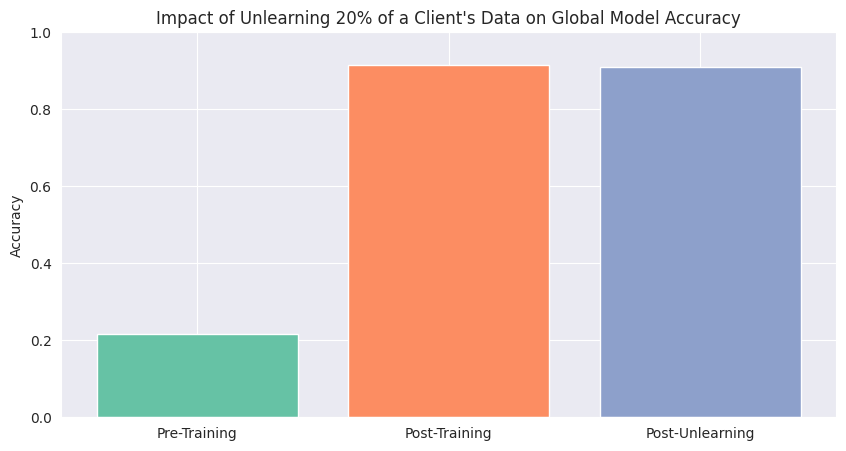

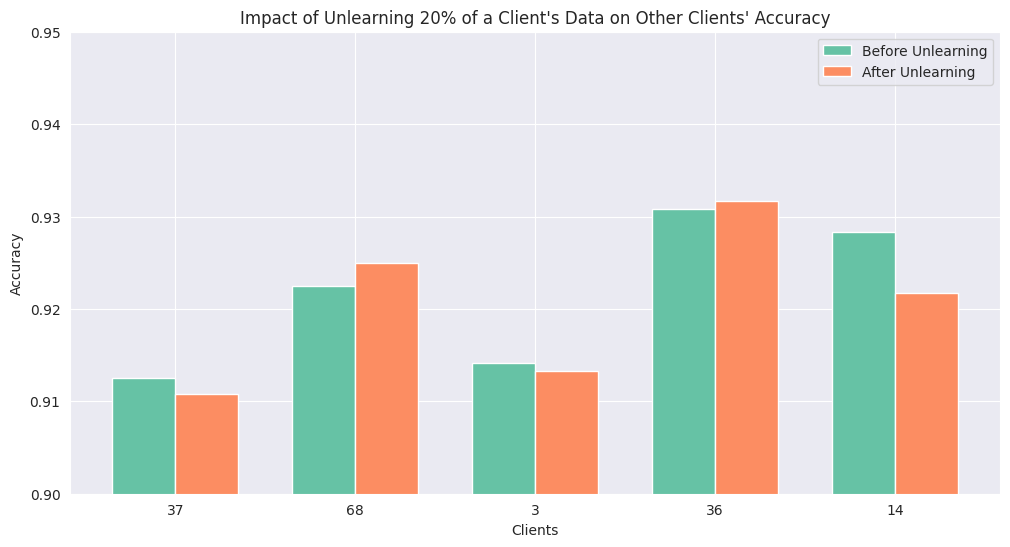

In [72]:
log_file_path_005 = 'archive/13_unlearning_no-non-iid/adaptive_prompt_fl_unlearning_agnews_full_c100_f0.1_r10_e20_p10_20241010_140730.log'
overall_accuracies_005, client_df_005 = extract_accuracies_from_log(log_file_path_005)

log_file_path_01 = 'archive/13_unlearning_no-non-iid/adaptive_prompt_fl_unlearning_agnews_full_c100_f0.1_r10_e20_p10_20241010_153238.log'
overall_accuracies_01, client_df_01 = extract_accuracies_from_log(log_file_path_01)

log_file_path_02 = 'archive/13_unlearning_no-non-iid/adaptive_prompt_fl_unlearning_agnews_full_c100_f0.1_r10_e20_p10_20241010_165750.log'
overall_accuracies_02, client_df_02 = extract_accuracies_from_log(log_file_path_02)


# plot_accuracies(overall_accuracies_005, client_df_005, 'for 5% Unlearning')
# plot_accuracies(overall_accuracies_01, client_df_01, 'for 10% Unlearning')
plot_accuracies(overall_accuracies_02, client_df_02, '20%', save_plot=True)

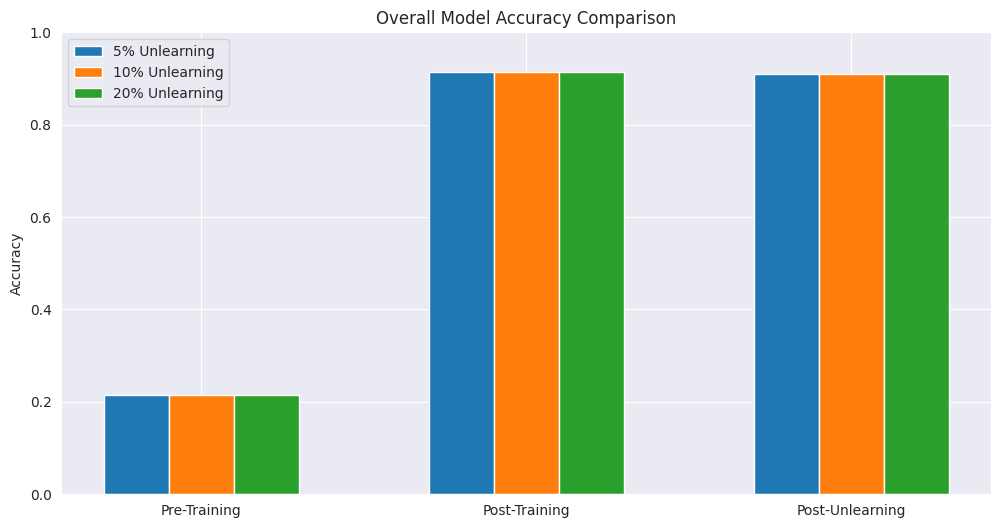

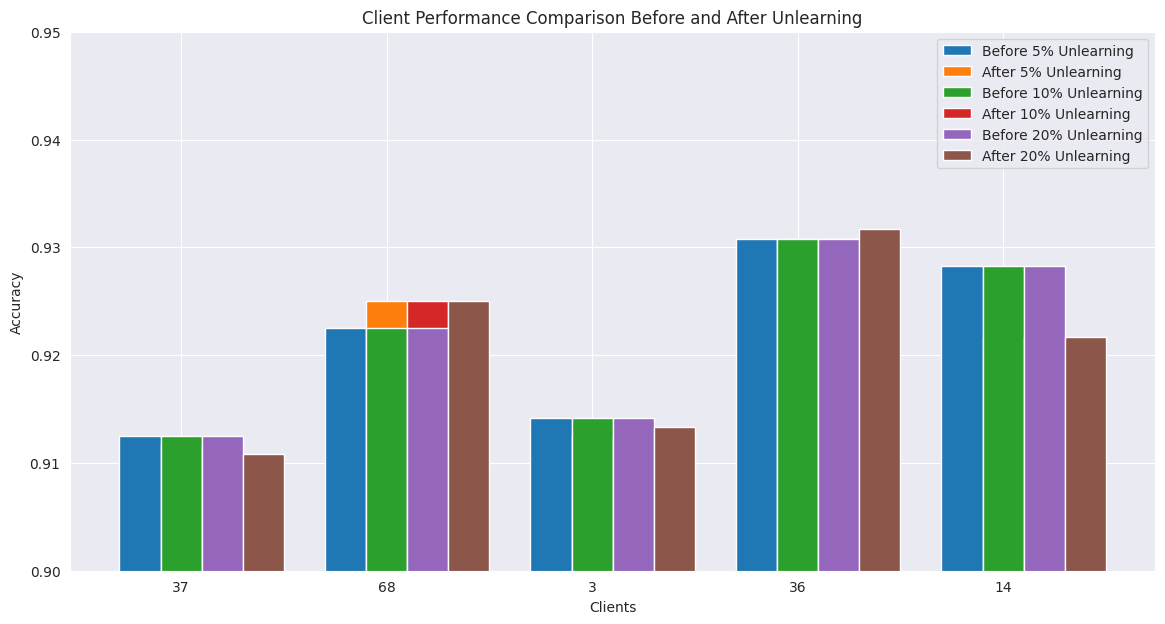

In [45]:
import matplotlib.pyplot as plt
import numpy as np

def plot_combined_accuracies(overall_accuracies_list, client_dfs, settings):
    # Plot combined overall accuracies
    plt.figure(figsize=(12, 6))
    x = np.arange(len(overall_accuracies_list[0]))  # Number of accuracy types (Pre, Post, Post-Unlearning)
    width = 0.2  # Width of the bars

    for i, (overall_accuracies, setting) in enumerate(zip(overall_accuracies_list, settings)):
        plt.bar(x + i * width, overall_accuracies.values(), width, label=f'{setting} Unlearning')

    plt.xticks(x + width, overall_accuracies_list[0].keys())
    plt.title('Overall Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

    # Plot combined client performance
    num_clients = len(client_dfs[0])
    x = np.arange(num_clients)  # Number of clients
    width = 0.2  # Width of the bars

    fig, ax = plt.subplots(figsize=(14, 7))
    for i, (client_df, setting) in enumerate(zip(client_dfs, settings)):
        ax.bar(x + i * width, client_df['Before Unlearning'], width, label=f'Before {setting} Unlearning')
        ax.bar(x + i * width + width, client_df['After Unlearning'], width, label=f'After {setting} Unlearning')

    ax.set_xlabel('Clients')
    ax.set_ylabel('Accuracy')
    ax.set_title('Client Performance Comparison Before and After Unlearning')
    ax.set_xticks(x + width)
    ax.set_xticklabels(client_dfs[0]['Client'])
    ax.legend()

    plt.ylim(0.9, 0.95)  # Adjust the y-axis limits for better visibility
    plt.show()

# Example usage
overall_accuracies_list = [overall_accuracies_005, overall_accuracies_01, overall_accuracies_02]
client_dfs = [client_df_005, client_df_01, client_df_02]
settings = ['5%', '10%', '20%']

plot_combined_accuracies(overall_accuracies_list, client_dfs, settings)

In [1]:
import tuna

ModuleNotFoundError: No module named 'tuna'

In [2]:
pip install tuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.7/149.7 kB 3.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
def tricky_loop():
    x = 0.1
    while x != 1.0:
        x += 0.1
        print(f"x = {x}")
    print("Done")

tricky_loop()